In [96]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

#from sklearn.utils.tests import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

##Seaborn for fancy plots. 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (8,8)
alphas = [.00001,.000025,.00005,.0001,.0005,.001,.01,.1,.25,.5,1.,2.,5,10]

# Linear Regression and Regularization

Linear regression works by building a model that assigns a coefficient to each of the terms, eg y = a1*x1 + a2*b2 + a3*x3 + b. These coefficients determine the relative importance of different features to the end result of the models. We also saw that it was pretty common for us to be able to create a model that was very close to as accurate after having removed some of the least important features - those with large p values. 

When dealing with datasets with large number of features, this problem can be amplified - the potential for overfitting is there because we have many, many features that have a slight impact to the final prediction. 

## Regularization

Regularization is a technique that helps to prevent overfitting by penalizing the model for growth. It does this by adding a term to the cost function that is a function of the size of the coefficients. This term is called the regularization term. In the context of regression, we then minimize that entire cost function, which includes the regularization term, instead of just the cost function. This means that models that are accurate have lower cost, and models that have smaller coefficients have lower cost. So we want a model that balances growing and being accurate. This allows models to have their growth controlled by the regularization term, leading to models that tend to have less variance error. 

![Regularization](../images/regularization.jpg "Regularization")

The balance of the two terms is controlled by a parameter that we provide to the model, and one that we can grid search over to find the best value. 

##### Load Data

We'll use a housing dataset that we've seen before to try with our regularized models. This dataset is an old one that is based on Boston housing prices. We can Google "boston housing dataset" to find a data dictionary for it all over the web, it doesn't matter much for this exercise. This dataset has 104 columns in it by default, and only 404 rows, so we are more likely than average to overfit. In general, we can think of overfitting, informally, as a model that picks up on patterns that rarely occur (in training data), then tries to apply them to new data, where they don't exist. If we have enough data, our model can see enough examples to distinguish one-offs from real patterns - the less data we have, the harder this is. The model complex (multiple features) we have, the worse this gets - the complex model can use lots of data to customize itself, and in doing so it finds things that just aren't common enough in data to be helpful overall. 

In [97]:
def resultPrinter(model, X_train, X_test, y_train, y_test, decimals=2):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    print("Train MSE: ", round(mean_squared_error(y_train, y_train_pred), decimals))
    print("Test MSE: ", round(mean_squared_error(y_test, y_test_pred), decimals), "\n")
    print("Train R2: ", round(r2_score(y_train, y_train_pred), decimals))
    print("Test R2: ", round(r2_score(y_test, y_test_pred), decimals))

In [98]:
from numpy import genfromtxt
dataset = genfromtxt('https://raw.githubusercontent.com/m-mehdi/tutorials/main/boston_housing.csv', delimiter=',')
X = dataset[:,:-1]
y = dataset[:,-1]
Xp_train, Xp_test, yp_train, yp_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Xp_train shape: ", Xp_train.shape)

Xp_train shape:  (404, 104)


#### Baseline Model

In [99]:
base_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ("model", LinearRegression())
])

base_pipe.fit(Xp_train, yp_train)
resultPrinter(base_pipe, Xp_train, Xp_test, yp_train, yp_test)

Train MSE:  5.13
Test MSE:  14.26 

Train R2:  0.94
Test R2:  0.81


Number of features used:  104


<Axes: ylabel='Count'>

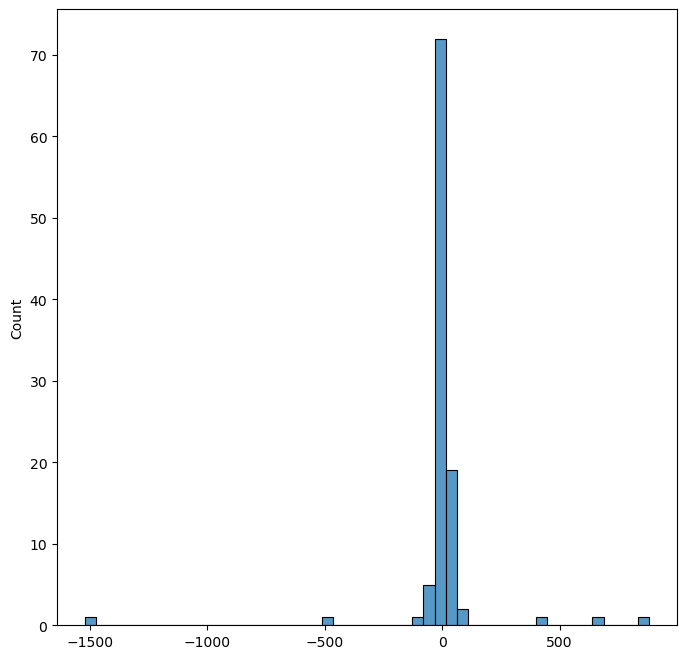

In [100]:
base_coef = base_pipe.named_steps["model"].coef_
print("Number of features used: ", np.sum(base_coef != 0))
sns.histplot(base_coef, bins=50)

#### Baseline Results

Our baseline model has a far better training score than test score, which is a sign of overfitting. We've hit the jackpot, since this is the exact problem that regularization is supposed to solve!

Right now our model is basically too tailored to the training data, meaning it predicts it very accurately, but when we give it new data to try to predict, it performs poorly. 

### Regularization

Regularization is a method for constraining the complexity of a linear regression model by limiting the coefficients. It functions by adding a penalty term to the cost function while training, this causes the algorithm to seek to minimize the weights when creating the model. We are effectively discouraging the model from being more complex - from incorporating a large number of features. 

Note: Scaling values is important when doing regularization. 

#### Ridge Regression - L2

Ridge regression adds a term to the cost function equal to the square of the magnitude of the coefficients. We can see from the example below, the higher that the alpha value, which defines the penalty amount, goes, the less varaiance the model is allowed to have. We are constraining it. An alpha of 0 makes the penalty term 0, and is just normal linear regression. As the alpha increases, the model becomes more and more constrained by the penalty term. The greater the impact of the penalty term, the more the model will be forced to reduce the coefficients, and the more that factor will be weighted against the "original" cost function.

![L2 Regularization](../images/l2_reg.jpeg "L2 Regularization" )

#### In Our Example

As we increease the 

In [101]:
l2_pipe = Pipeline([
    ("scaler", MinMaxScaler()),
    ("impute", SimpleImputer()),
    ("ridge_reg", Ridge())
])

l2_params = {
    'ridge_reg__alpha': alphas
}

l2_grid = GridSearchCV(l2_pipe, l2_params, cv=5, n_jobs=-1, verbose=1)
l2_grid.fit(Xp_train, yp_train)
print("Best alpha: ", l2_grid.best_params_)
resultPrinter(l2_grid, Xp_train, Xp_test, yp_train, yp_test)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


Best alpha:  {'ridge_reg__alpha': 0.1}
Train MSE:  6.92
Test MSE:  10.92 

Train R2:  0.92
Test R2:  0.85


Number of features used:  104


<Axes: ylabel='Count'>

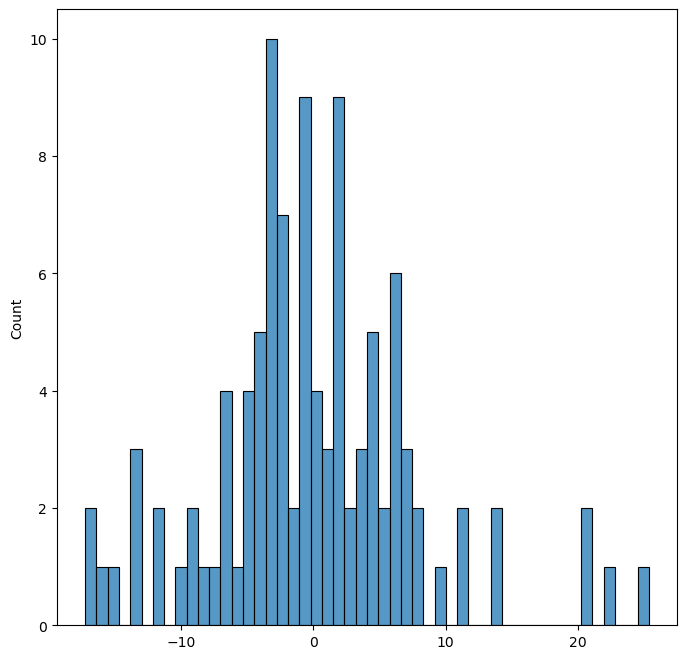

In [102]:
l2_coef = l2_grid.best_estimator_.named_steps['ridge_reg'].coef_
print("Number of features used: ", np.sum(l2_coef != 0))
sns.histplot(l2_coef, bins=50, kde=False)

### Lasso Regression

Lasso regression also adds a penalty term to the cost function, this one is based on the absolute value of the magnitude of the cost function. 

![L1 Regularization](../images/l1_reg.jpeg "L1 Regularization" )

The process inside of the lasso regression is similar to the ridge regression, but the penalty term is different. The lasso regression will actually set some of the coefficients to 0, effectively removing them from the model. This is a form of feature selection that we can get "for free" by using the lasso regression. As well, since absolute value calculations are not differentiable, the lasso regression is not differentiable, and thus cannot be solved with normal gradient descent; the estimating to work with the absolute values will slow the process. 

In [103]:
l1_pipe = Pipeline([
    ("scaler", MinMaxScaler()),
    ("impute", SimpleImputer()),
    ("lasso_reg", Lasso(max_iter=10000))
])

l1_params = {
    "lasso_reg__alpha": alphas
}

l1_grid = GridSearchCV(l1_pipe, l1_params, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
l1_grid.fit(Xp_train, yp_train)
print("Best alpha: ", l1_grid.best_params_)
resultPrinter(l1_grid, Xp_train, Xp_test, yp_train, yp_test)

/Users/akeem/anaconda3/envs/ml_2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.650e+02, tolerance: 2.948e+00
  model = cd_fast.enet_coordinate_descent(
/Users/akeem/anaconda3/envs/ml_2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.092e+02, tolerance: 2.710e+00
  model = cd_fast.enet_coordinate_descent(
/Users/akeem/anaconda3/envs/ml_2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

Best alpha:  {'lasso_reg__alpha': 0.01}
Train MSE:  9.68
Test MSE:  11.86 

Train R2:  0.89
Test R2:  0.84


Number of features used:  38


<Axes: ylabel='Count'>

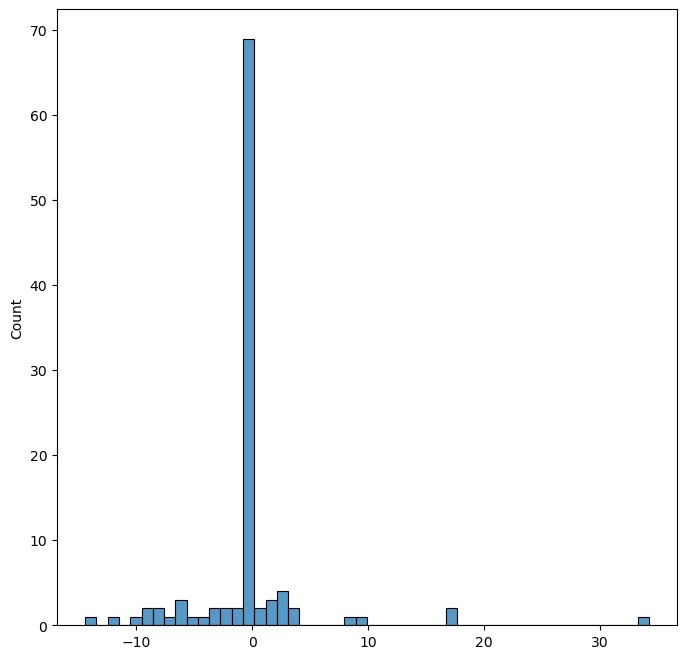

In [104]:
l1_coef = l1_grid.best_estimator_.named_steps['lasso_reg'].coef_
print("Number of features used: ", np.sum(l1_coef != 0))
sns.histplot(l1_coef, bins=50, kde=False)

#### Test Multiple Alphas

We can also improvise a loop to test multiple alphas and see which one works best, like a broken out grid search.

In [105]:
model_results = []

for alpha in alphas:
    l1_mod = Lasso(alpha=alpha, max_iter=10000)
    l1_mod.fit(Xp_train, yp_train)
    l1_train_preds = l1_mod.predict(Xp_train)
    l1_test_preds = l1_mod.predict(Xp_test)
    l1_train_mse = mean_squared_error(yp_train, l1_train_preds)
    l1_test_mse = mean_squared_error(yp_test, l1_test_preds)
    l1_train_r2 = r2_score(yp_train, l1_train_preds)
    l1_test_r2 = r2_score(yp_test, l1_test_preds)
    model_results.append({
        "alpha": alpha,
        "model": "Lasso",
        "train_mse": l1_train_mse,
        "test_mse": l1_test_mse,
        "train_r2": l1_train_r2,
        "test_r2": l1_test_r2
    })
    l2_mod = Ridge(alpha=alpha, max_iter=10000)
    l2_mod.fit(Xp_train, yp_train)
    l2_train_preds = l2_mod.predict(Xp_train)
    l2_test_preds = l2_mod.predict(Xp_test)
    l2_train_mse = mean_squared_error(yp_train, l2_train_preds)
    l2_test_mse = mean_squared_error(yp_test, l2_test_preds)
    l2_train_r2 = r2_score(yp_train, l2_train_preds)
    l2_test_r2 = r2_score(yp_test, l2_test_preds)
    model_results.append({
        "alpha": alpha,
        "model": "Ridge",
        "train_mse": l2_train_mse,
        "test_mse": l2_test_mse,
        "train_r2": l2_train_r2,
        "test_r2": l2_test_r2
    })
model_results = pd.DataFrame(model_results)
model_results["Model_name"] = model_results["model"] + "_" + model_results["alpha"].astype(str)
model_results["fit_gap"] = model_results["train_mse"] - model_results["test_mse"]
model_results["r2_gap"] = model_results["train_r2"] - model_results["test_r2"]

/Users/akeem/anaconda3/envs/ml_2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.032e+03, tolerance: 3.510e+00
  model = cd_fast.enet_coordinate_descent(
/Users/akeem/anaconda3/envs/ml_2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.003e+03, tolerance: 3.510e+00
  model = cd_fast.enet_coordinate_descent(
/Users/akeem/anaconda3/envs/ml_2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

#### Capture Results

We can capture the results of the regularization and compare them to the baseline model. We can also look and see which best tackled the overfitting problem, at least by our definition of training vs test score that we used to queue us to look into it in the first place. 

In [106]:
model_results.sort_values("test_r2", ascending=False).head(10)

,alpha,model,train_mse,test_mse,train_r2,test_r2,Model_name,fit_gap,r2_gap
15,0.1000,Ridge,7.642317,10.921294,0.912029,0.851074,Ridge_0.1,-3.278977,0.060955
17,0.2500,Ridge,8.797212,11.041831,0.898735,0.849430,Ridge_0.25,-2.244619,0.049305
10,0.0010,Lasso,6.265413,11.328773,0.927879,0.845518,Lasso_0.001,-5.063360,0.082361
19,0.5000,Ridge,10.016345,11.569083,0.884702,0.842241,Ridge_0.5,-1.552739,0.042461
8,0.0005,Lasso,5.651542,12.046461,0.934945,0.835731,Lasso_0.0005,-6.394920,0.099214
13,0.0100,Ridge,5.948041,12.132860,0.931532,0.834553,Ridge_0.01,-6.184818,0.096979
21,1.0000,Ridge,11.625564,12.637243,0.866178,0.827675,Ridge_1.0,-1.011679,0.038503
12,0.0100,Lasso,10.523626,12.862609,0.878863,0.824602,Lasso_0.01,-2.338982,0.054261
6,0.0001,Lasso,5.246237,13.364399,0.939611,0.817759,Lasso_0.0001,-8.118162,0.121851
11,0.0010,Ridge,5.256763,13.403713,0.939489,0.817223,Ridge_0.001,-8.146950,0.122266


In [107]:
model_results.sort_values("r2_gap", ascending=False).head(3)

,alpha,model,train_mse,test_mse,train_r2,test_r2,Model_name,fit_gap,r2_gap
1,0.000010,Ridge,5.143847,14.196504,0.940789,0.806412,Ridge_1e-05,-9.052658,0.134377
3,0.000025,Ridge,5.151026,14.153100,0.940707,0.807004,Ridge_2.5e-05,-9.002074,0.133702
5,0.000050,Ridge,5.159584,14.110980,0.940608,0.807579,Ridge_5e-05,-8.951396,0.133029


In [108]:
model_results.sort_values("r2_gap", ascending=False).tail(3)

,alpha,model,train_mse,test_mse,train_r2,test_r2,Model_name,fit_gap,r2_gap
24,5.0,Lasso,86.873404,75.045430,0.000000,-0.023341,Lasso_5.0,11.827973,0.023341
26,10.0,Lasso,86.873404,75.045430,0.000000,-0.023341,Lasso_10.0,11.827973,0.023341
20,1.0,Lasso,64.777902,54.671296,0.254341,0.254487,Lasso_1.0,10.106606,-0.000146


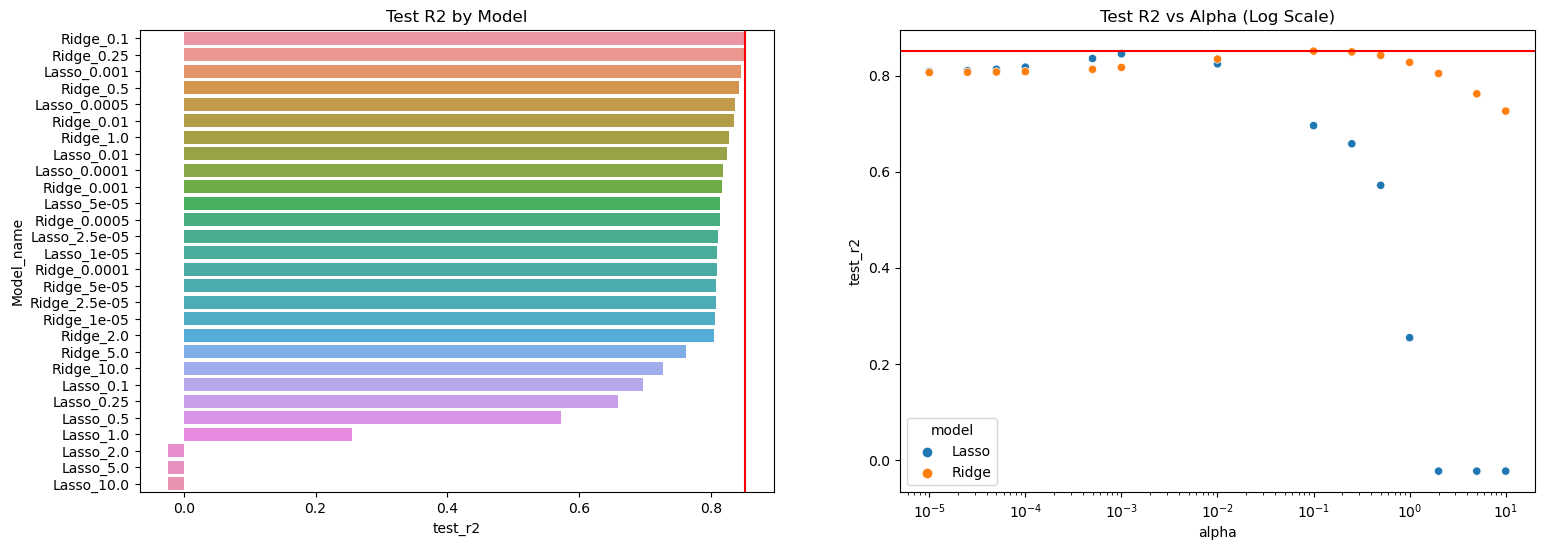

In [113]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax[0].axvline(x=np.max(model_results["test_r2"]), color="red")
ax[0].title.set_text("Test R2 by Model")
sns.barplot(data=model_results.sort_values("test_r2", ascending=False), y="Model_name", x="test_r2", ax=ax[0])

#ax[1].axhline(y=np.max(model_results["test_r2"]), color="red")
#ax[1].title.set_text("Test R2 vs Alpha (Log Scale)")
#sns.scatterplot(data=model_results, x="alpha", y="test_r2", hue="model", ax=ax[1])
#plt.xscale("log")
sns.barplot(data=model_results.sort_values("r2_gap", ascending=False), 
plt.show()

## Regularization Usage

Regularization is extremely common in data science work, it is one of the most common techniques to prevent overfitting. Both of these regularization techniques do the same thing similarly - they penalize having larger weights, thereby incentivizing models that are more stable. Some important differences are:

<ul>
<li> L1 can encourage weights to go to 0, so it can write out some variables entirely. </li>
<li> L1's absolute value makes the cost function is non-differentiable - meaning that you can't take the derivitive for gradients. So the algorithm needs to simulate that, which is slower. This is a major reason that we see L2 more commonly, especially in neural networks, as the performance difference can add up when it is calculated millions of times. </li>
</ul>

#### Picturing Regularization

Regularization impacts can be visualized by an image similar to the one below. Think of this as being the calculation for one feature. Instead of reaching a weight that is "optimal" (the middle of the rings) as you would using standard least squared regression, regularization needs to balance that amount of error (the rings) with the penalty term (the circle/diamond). So the finalized weights is where these two intersect - where the "real" error and the penalty error are in balance:

![Regularization](../images/regularization_rings.jpeg "Regularization" )

## Elastic Net

The third type of regularization is called Elastic Net, and it is just a blend of L1 and L2. We can implement this in the same way as the Ridge/Lasso, one thing that we can set is the blend between L1 and L2 - controlled by a HP called "l1_ratio", which is simply what percentage of the penalty term is L1 vs L2. In this example use a grid search to find the best. 

![Elastic Net](../images/elastic_net.png "Elastic Net" )

This is basically a compromise between the two types of regularization seen above, as it is just a weighted average of the two penalty terms.

![EN Error](../images/el_error.png "EN Error" )

### Selecting Regularization Types

All of these regularization methods do, broadly, the same thing. They penalize the cost function for having large weights, and thus encourage the model to be more stable. This will generally limit the overfitting of the model, and thus improve the performance on test data. Regularization can be used to this effect wherever gradient descent is used - most notably in neural networks that we'll look at later. Each type of regularization has its own benefits and drawbacks, and we can use that information, in combination with a good old fashioned grid search, to find the best model for our data.
<ul>
<li> <b>L1 Regularization:</b>
    <ul>
    <li> Allows for feature selection, as it can set some coefficients to 0.
    <li> Computationally slower. 
    <li> Selecting out features can be helpful for interpretability.
    <li> Can yeild a sparse model (mostly 0s). (We'll talk more about this with neural networks)
    </ul>
<li> <b>L2 Regularization:</b>
    <ul>
    <li> Reduces impact of the less important features, without removing them.
    <li> Computationally quick since it is differentiable.
    <li> Yeilds a dense model, which is what we are used to. 
    </ul>
<li> <b>Elastic Net Regularization:</b>
    <ul>
    <li> Algebraic blend of the previous two.
    <li> Computationally slower than either. 
    <li> Can be used in a grid search to find the best choice of the above two, or the optimal blend.
    </ul>
</ul>

In general, we want to use L2 as it is the quickest, unless there's some reason not to. This could be the desire to perform feature selection or because we've tested a more accurate chocie for our data. 

#### Example - Elastic Net

Predict the car price from data above using elastic net. Use a grid search to find the best blend of L1 and L2 regularization.

In [110]:
el_pipe = Pipeline([
    ("scaler", MinMaxScaler()),
    ("impute", SimpleImputer()),
    ("elastic_net", ElasticNet(max_iter=10000))
])

el_params = {
    "elastic_net__alpha": alphas,
    "elastic_net__l1_ratio": np.linspace(.00001, 1, 11)
}

el_grid = GridSearchCV(el_pipe, el_params, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
el_grid.fit(Xp_train, yp_train)
resultPrinter(el_grid, Xp_train, Xp_test, yp_train, yp_test)

/Users/akeem/anaconda3/envs/ml_2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.089e+02, tolerance: 2.710e+00
  model = cd_fast.enet_coordinate_descent(
/Users/akeem/anaconda3/envs/ml_2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.606e+02, tolerance: 2.948e+00
  model = cd_fast.enet_coordinate_descent(
/Users/akeem/anaconda3/envs/ml_2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

Train MSE:  7.18
Test MSE:  10.86 

Train R2:  0.92
Test R2:  0.85


/Users/akeem/anaconda3/envs/ml_2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.575e+01, tolerance: 3.510e+00
  model = cd_fast.enet_coordinate_descent(


## Exercise

Here's a bit of a more open-ended challenge... your goal here is to use some data about AirBnB listings to make a model that can predict prices. The one difference is that we want it to work across cities, so we are training it on one city, and testing it on another, just as if we were spearheading a massive expansion into a new market. This will impact some features and their relevance, you'll need to evaluate what is important and what is not.

<ol>
<li> Load in ANY one of the datasets from: https://www.kaggle.com/datasets/thedevastator/airbnb-prices-in-european-cities?select=lisbon_weekdays.csv </li>
    <ul>
    <li><b> Note: I put 4 of these files in the data folder of this repository, you can find them in here: https://github.com/AkeemSemper/ML_for_Non_DS_Students/tree/main/data prefaced by "abnb_". </b></li>
    <li> You can download these files directly in code by using the raw file link on GitHub. There are examples of the code to do this in several previous notebooks, near the top there are !wget commands, these download a file at that URL to the current directory in Colab. </li>
    <li> Each file on GitHub has a "Raw" button that will link to that raw file, Google "GitHub get raw file link" to see detailed instructions with screenshots. You can just replace the URL from one of my lnes of downloading with yours, and it'll work the same. </li>
    </ul>
<li> Use the <b>realSum</b> column as the target variable - it is the total price of the listing. </li>
<li> Use the other data as features to train a model, using techniques like feature selection, imputation, scaling, encoding, etc... to make things work. </li>
<li> Try, at least a bit, to get the model to be as accurate as possible through testing and training. </li>
<li> Once your model is trained and ready to go, <b><i>you want to use it to predict the price of new listings from ANOTHER dataset from that page.</i></b> </li>
<li> Download a different dataset, and use your model to predict the price of the listings in that dataset. Note - think about what would need to be done to the data prior to going into predict(). </li>
<li> Compare these new City #2 predicitons to their real value, this is the "test accuracy" of your model, in a real-ish scenario. </li>
<li><b> If you're able to do this, try to make the code more reusable - can you make a function that will take in a dataset and a flag to 'predict' or 'train', and do the appropriate thing? </b></li>
</ol>

Try some things out, without much structure, and ask if you hit a roadblock. I'd expect that you'd hit at least a couple of places where things either don't work directly, or the results may be weird, that might cause you to track down the cause, troubleshoot, and fix it. This is a big part of doing data science or programming in general, so despite frustrations, it really is required. 
